In [1]:
!apt-get install git
!git clone https://github.com/afyanyan/SN.git
%cd SN/Database/Process_Data
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern, RationalQuadratic as RQ, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Cloning into 'SN'...
remote: Enumerating objects: 442, done.
remote: Counting objects: 100% (442/442), done.
remote: Compressing objects: 100% (393/393), done.
remote: Total 442 (delta 112), reused 186 (delta 38), pack-reused 0 (from 0)
Receiving objects: 100% (442/442), 849.49 KiB | 3.73 MiB/s, done.
Resolving deltas: 100% (112/112), done.
/content/SN/Database/Process_Data


In [2]:
SN_name = input("Enter SN name: ")
file = SN_name + "_frg_r.csv"
frg_r_all = pd.read_csv(file)
display(frg_r_all)

Enter SN name: SN2023mpz


Unnamed: 0           MJD filter  unforced_mag  unforced_mag_error  \
0            0  60285.133507      r        19.721               0.189   
1            2  60268.133310      r        19.771               0.271   
2            5  60260.109572      r        19.719               0.184   
3            8  60255.145833      r        19.723               0.161   
4           11  60253.144595      r        19.689               0.172   
5           12  60251.184711      r        19.653               0.151   
6           19  60245.161840      r        19.681               0.208   
7           21  60239.222697      r        19.642               0.173   
8           24  60237.183565      r        19.621               0.129   
9           26  60235.139028      r        19.504               0.111   
10          28  60233.153368      r        19.471               0.113   
11          30  60231.158171      r        19.450               0.126   
12          32  60228.162026      r        19.177               0.120   
13          33  60226.224074      r        19.122               0.092   
14          36  60223.185521      r        18.910               0.075   
15          37  60221.288530      r        18.725               0.142   
16          39  60217.152616      r        18.445               0.074   
17          41  60215.234259      r        18.319               0.076   
18          43  60213.192732      r        18.218               0.060   
19          46  60211.149005      r        18.188               0.052   
20          48  60207.186643      r        18.091               0.053   
21          49  60205.206736      r        18.040               0.065   
22          52  60203.212662      r        18.010               0.043   
23          54  60198.269005      r        17.928               0.051   
24          57  60195.233206      r        17.925               0.050   
25          58  60195.233206      r        17.925               0.050   
26          59  60193.269792      r        17.897               0.051   
27          61  60187.242651      r        17.924               0.084   
28          63  60185.251898      r        17.860               0.050   
29          65  60183.374792      r        17.848               0.062   
30          68  60181.234688      r        17.887               0.059   
31          72  60174.255660      r        17.861               0.053   
32          73  60172.277569      r        17.833               0.050   
33          74  60172.277569      r        17.833               0.050   
34          77  60170.275104      r        17.842               0.044   
35          79  60168.318079      r        17.820               0.062   
36          80  60164.291806      r        17.770               0.038   
37          82  60162.315729      r        17.764               0.057   
38          84  60160.282731      r        17.756               0.058   
39          85  60156.357581      r        17.686               0.058   
40          89  60152.320116      r        17.665               0.043   
41          92  60148.351933      r        17.594               0.049   
42          94  60146.342604      r        17.562               0.058   
43          95  60146.327431      r        17.547               0.049   
44          97  60144.308264      r        17.500               0.043   
45         101  60138.452500      r        17.382               0.048   
46         104  60136.401227      r        17.428               0.041   
47         105  60134.422025      r        17.551               0.039   

   unforced_mag_status  forced_ujy  forced_ujy_error  
0             positive         NaN               NaN  
1             positive        46.1               5.6  
2             positive        45.6               5.2  
3             positive        46.4               3.5  
4             positive        49.1               3.6  
5             positive        50.3               4.3  
6             positive        46.4       

In [3]:
def plot_fig(X,y,X_test,y_pred,sigma, removed_set,N_loop,random,no_points_removed):
    plt.close()
    plt.figure(figsize=(10, 6))
    plt.plot(X, y, 'ro', label="Observed Data")  # Original data points
    plt.plot(X_test, y_pred, 'b-', label="GPR Prediction")  # Mean prediction
    plt.fill_between(X_test.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, color='blue', alpha=0.2, label="95% Confidence Interval")
    if random:
      Xr = removed_set[['MJD']].values
      Yr = removed_set[['unforced_mag']].values
      plt.scatter(Xr, Yr, color='black', label="Removed Points")
    elif random==False and no_points_removed==False:
      Xr = removed_set.iloc[0]['MJD']
      Yr = removed_set.iloc[0]['unforced_mag']
      plt.scatter(Xr, Yr, color='black', label="Removed Points")
    plt.ylim([17,21])
    plt.xlabel("MJD")
    plt.ylabel("Unforced Magnitude")
    plt.gca().invert_yaxis()
    plt.title("Gaussian Process Regression for MJD vs Unforced Magnitude")
    plt.legend()
    plt.show()
    return()

In [4]:
from random import randint
def random_point_removal(frg_r, N_remove): #randomly selects points to remove
  if N_remove!=0:
    reduced_set = frg_r_all.sample(n=len(frg_r_all) - N_remove).sort_values(by='MJD')
    return reduced_set

In [5]:
def nonrandom_point_removal(frg_r,i): #removes points sequentially
  reduced_set = frg_r.copy()
  reduced_set = reduced_set.drop(i-1)
  return reduced_set

In [6]:
def GPR(X,y,plot,random,N_loop):
    # Define kernel (e.g., Constant Kernel * RBF Kernel)
    kernel = C(1.0, (1e-3, 1e3)) * RQ(length_scale=1.0, alpha=1.0, length_scale_bounds=(1e-2, 1e2), alpha_bounds=(1e-5, 1e5))* Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=1.5) #Farhan's kernel (kernel 7)
    # Initialize Gaussian Process Regressor
    gpr = GaussianProcessRegressor(kernel=kernel, random_state=42)
    reduced_set = pd.DataFrame()
    removed_set = pd.DataFrame()
    if random == True:
      reduced_set = random_point_removal(frg_r_all.copy(), N_remove) #find set with removed points
      removed_set = frg_r_all.copy()
      removed_set = pd.DataFrame(removed_set.drop(reduced_set.index))
    else:
      reduced_set = nonrandom_point_removal(frg_r_all,i)
      removed_set = frg_r_all.copy()
      removed_set = pd.DataFrame(removed_set.drop(reduced_set.index))


    X = reduced_set[['MJD']].values
    y = reduced_set[['unforced_mag']].values
    # Fit to the data
    gpr.fit(X, y)

    # Predict with uncertainty
    X_test = np.linspace(X.min(), X.max(), 1000).reshape(-1, 1)
    y_pred, sigma = gpr.predict(X_test, return_std=True)

    idx = np.argmax(y_pred)
    t_sbo = X_test[idx].item()
    print ("Shock break out time = ", t_sbo)

    if plot:
      if random:
        plot_fig(X,y,X_test,y_pred,sigma, removed_set,N_loop,random=True,no_points_removed=False)
      else:
        plot_fig(X,y,X_test,y_pred,sigma, removed_set,N_loop,random=False,no_points_removed=False)
    return (t_sbo)

In [7]:
def GPR_all(X,y,plot):
  # Define kernel (e.g., Constant Kernel * RBF Kernel
    kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
    # Initialize Gaussian Process Regressor
    gpr = GaussianProcessRegressor(kernel=kernel, random_state=42)
    # Fit to the data
    gpr.fit(X, y)

    # Predict with uncertainty
    X_test = np.linspace(X.min(), X.max(), 1000).reshape(-1, 1)
    y_pred, sigma = gpr.predict(X_test, return_std=True)

    idx = np.argmax(y_pred)
    t_sbo = X_test[idx].item()
    print ("Shock break out time = ", t_sbo)


    if plot:
        plot_fig(X,y,X_test,y_pred,sigma,0,0,False,True)

    return (t_sbo)

Enter number of iterations: 47
Enter number of points to remove per iteration (0 for Nonrandom Point Removal): 0
Print Graphs? (Yes or No): Yes
1


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Shock break out time =  60266.928703828824


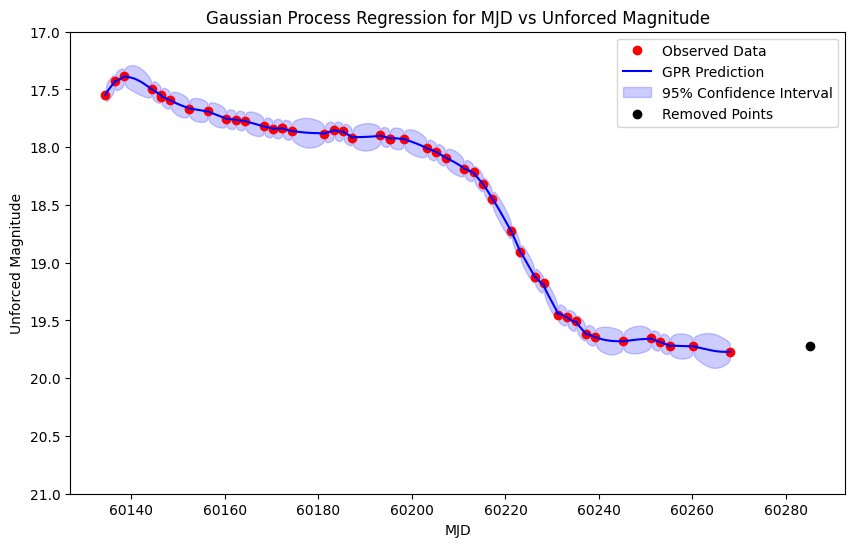

2
Shock break out time =  60276.38349102803


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


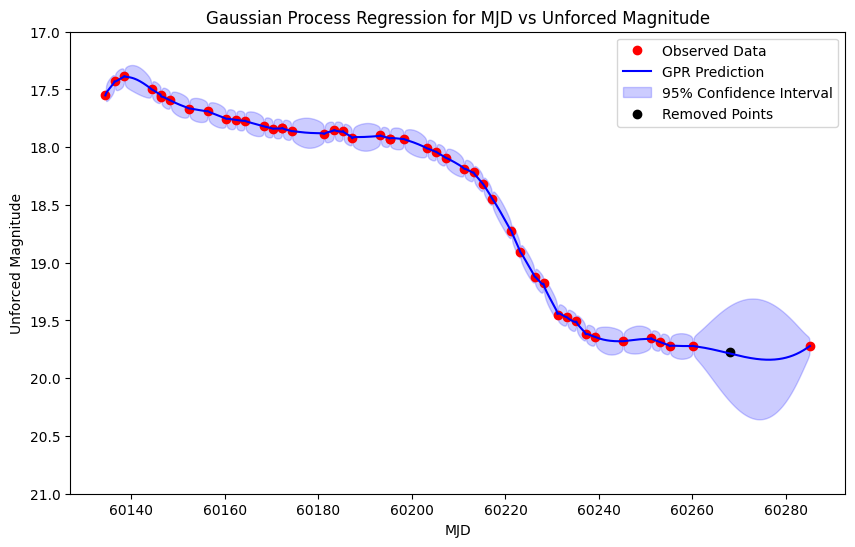

3


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Shock break out time =  60277.13780274975


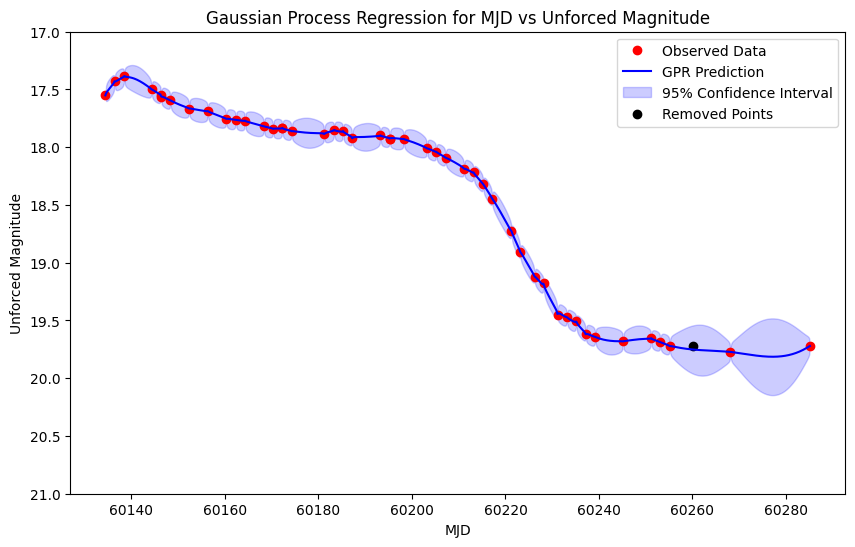

4
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


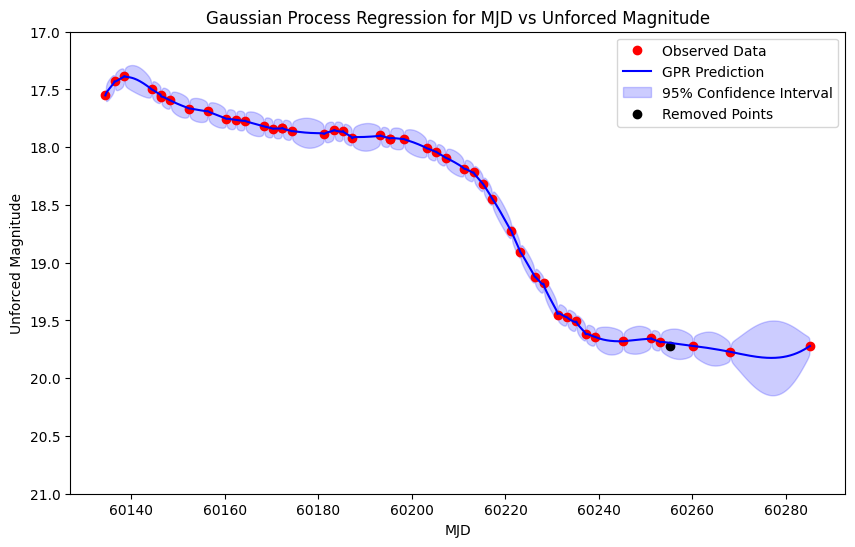

5
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


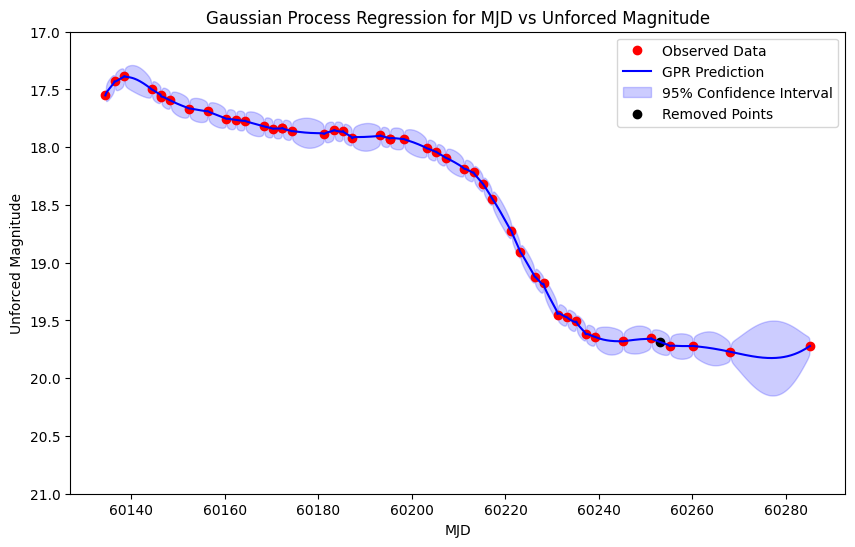

6
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


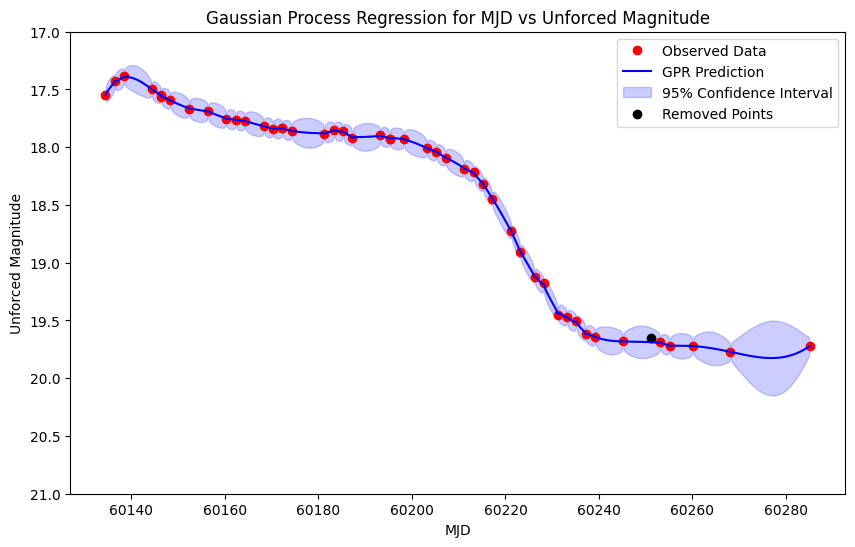

7
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


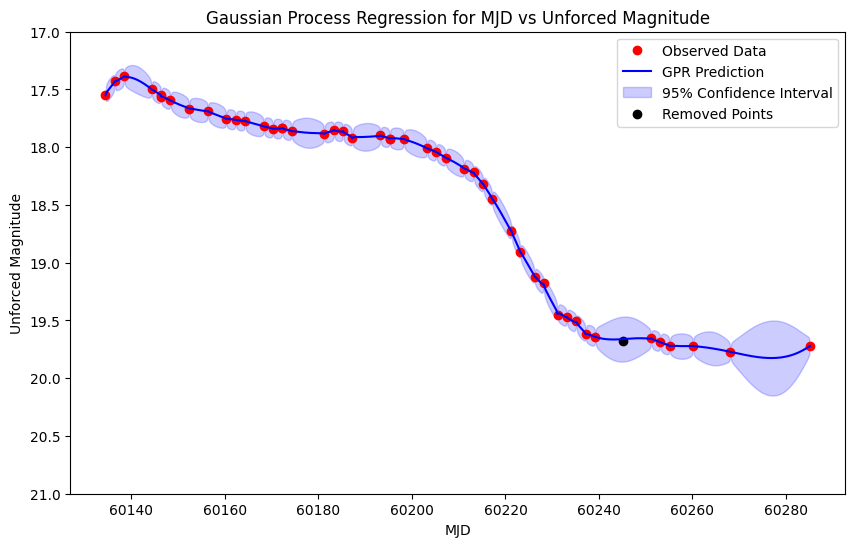

8
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


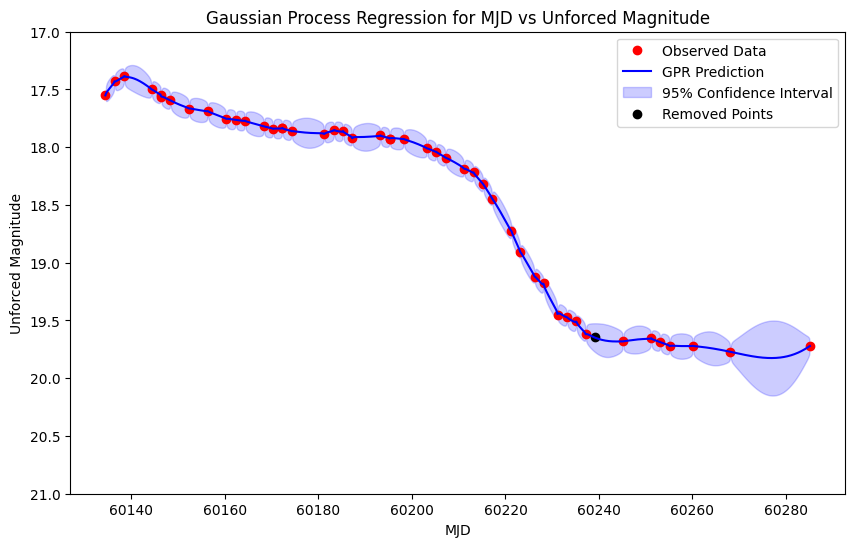

9
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


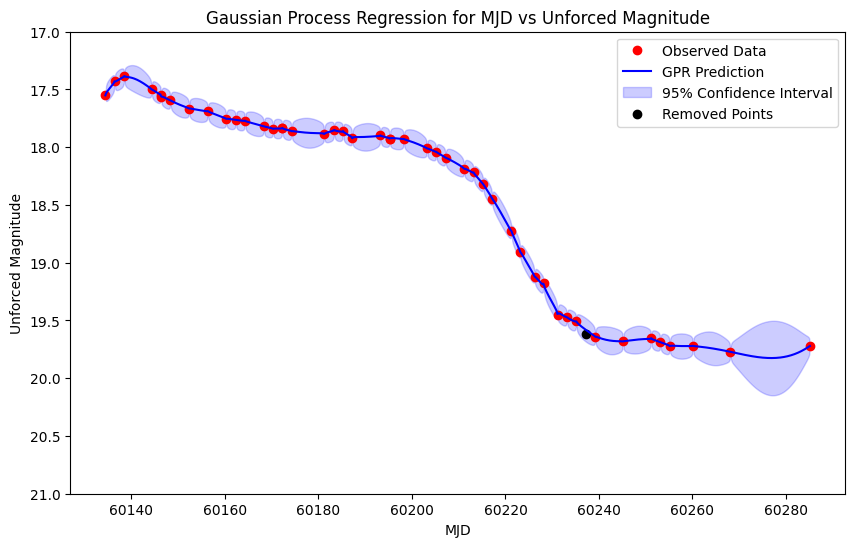

10
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


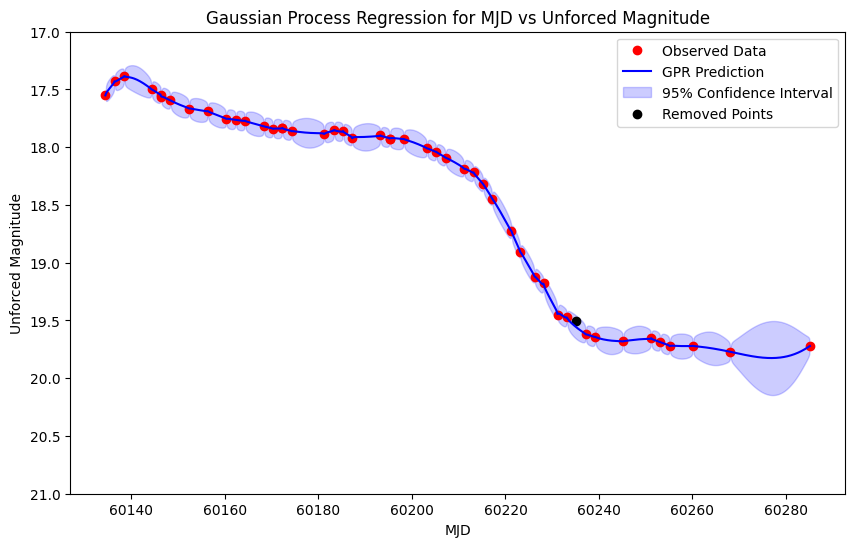

11
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


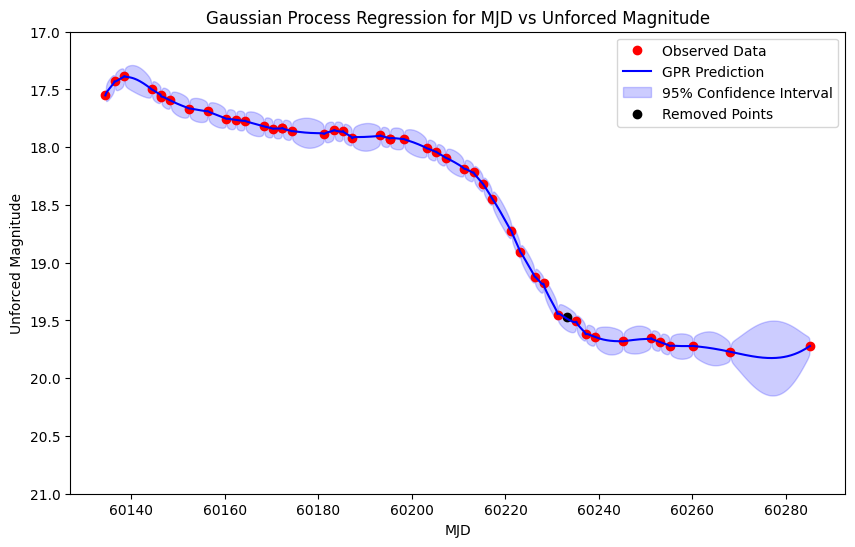

12
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


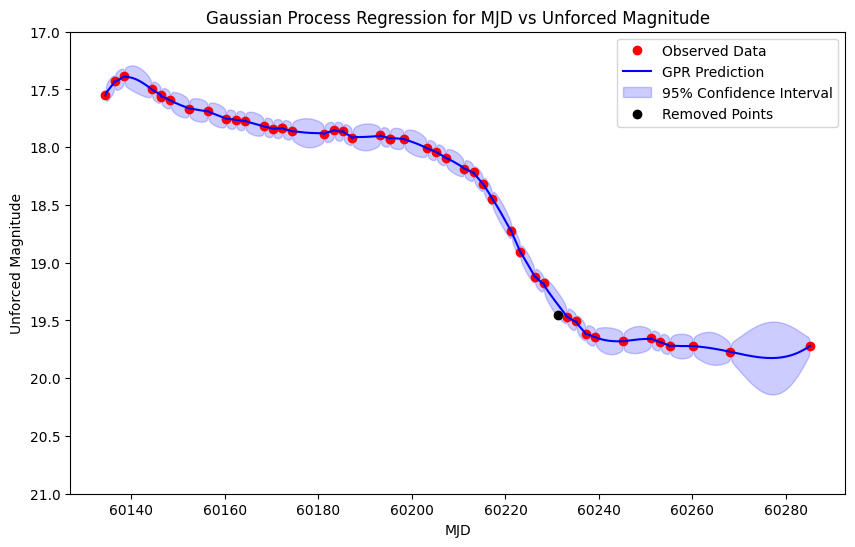

13
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


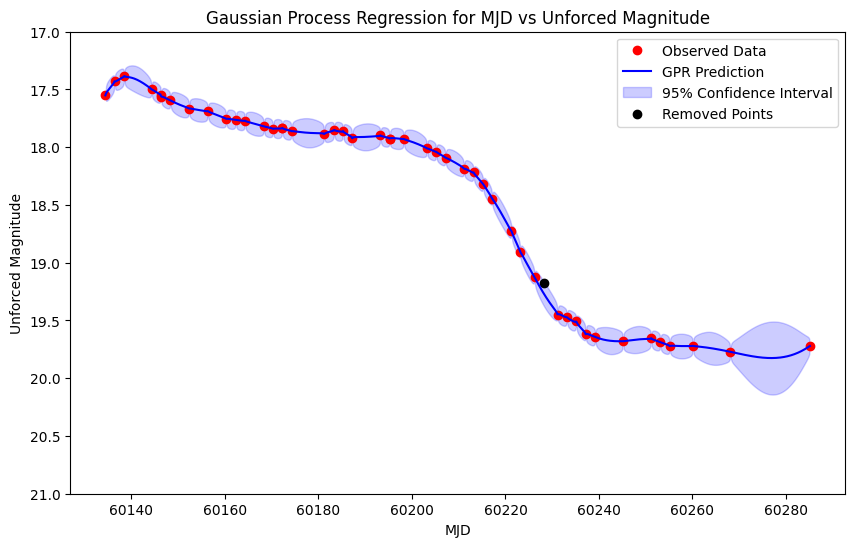

14
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


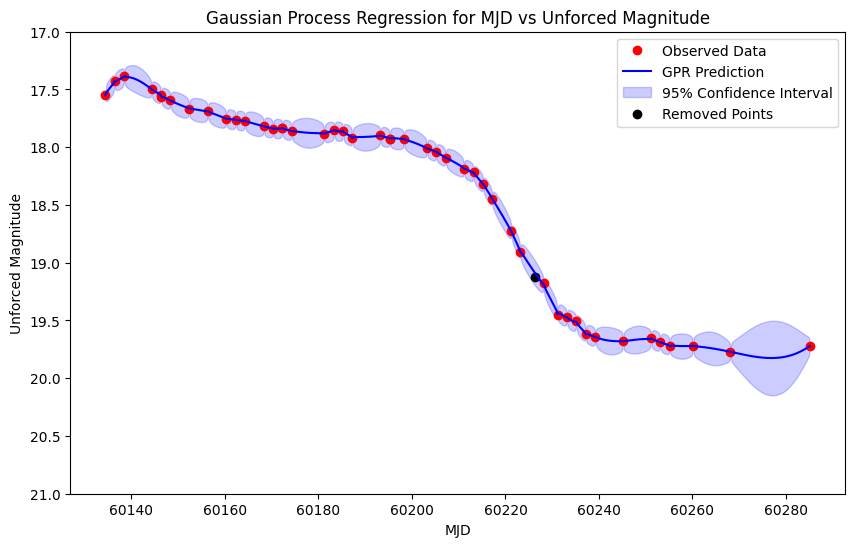

15
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


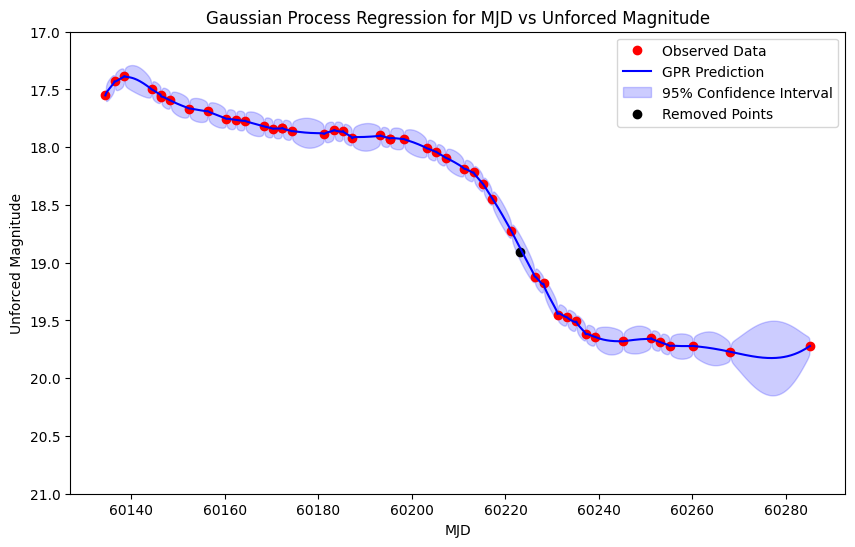

16


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Shock break out time =  60276.83607806106


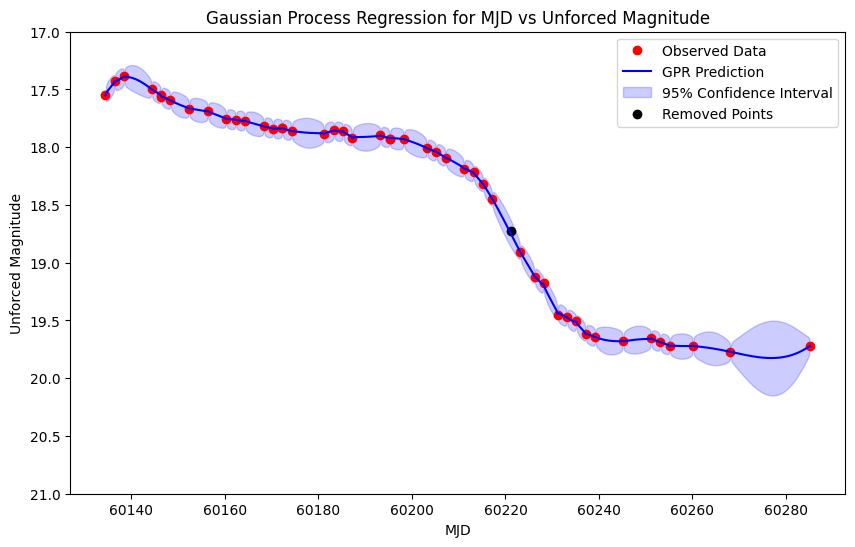

17


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Shock break out time =  60276.83607806106


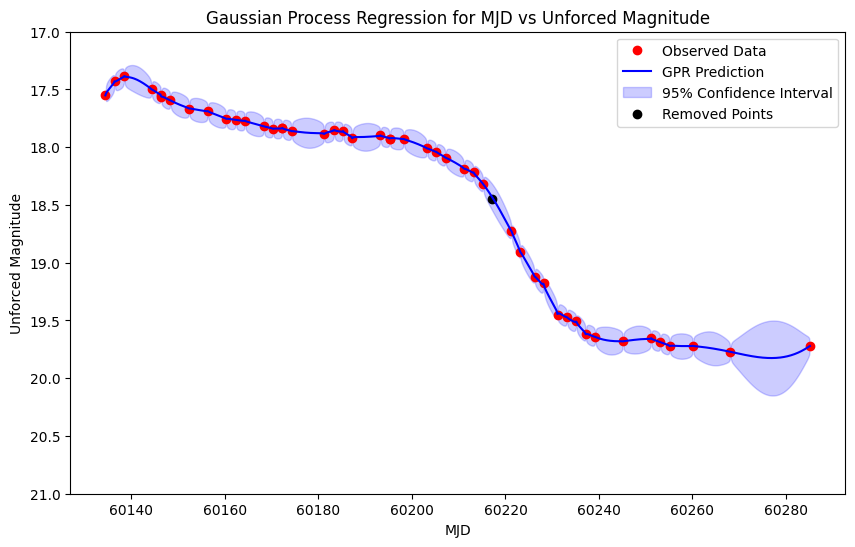

18


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Shock break out time =  60276.83607806106


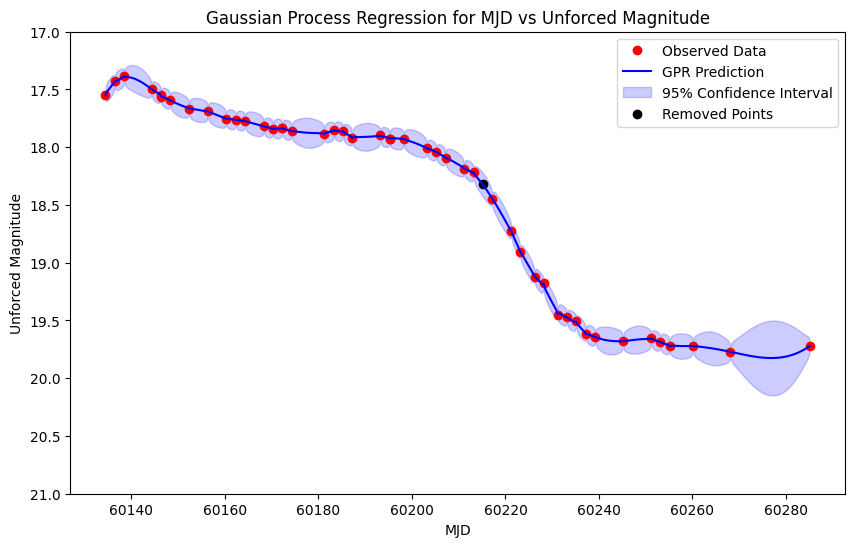

19


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Shock break out time =  60276.83607806106


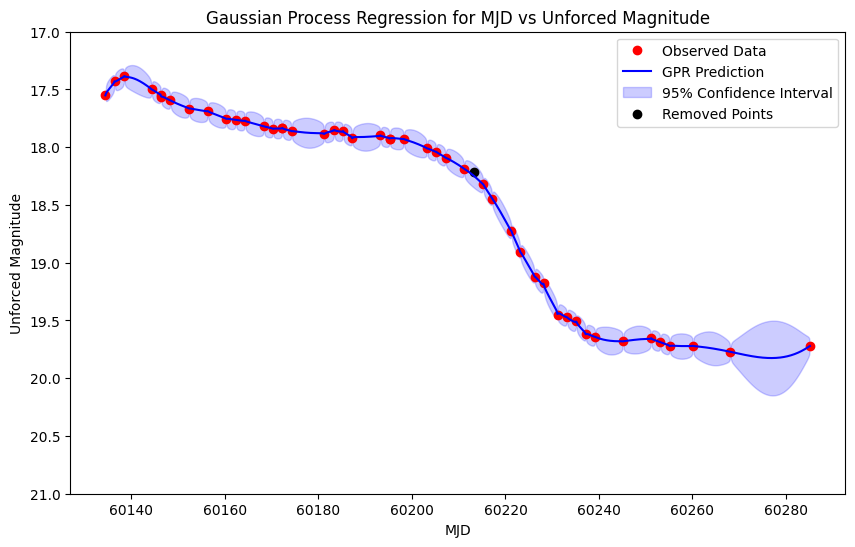

20


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Shock break out time =  60276.83607806106


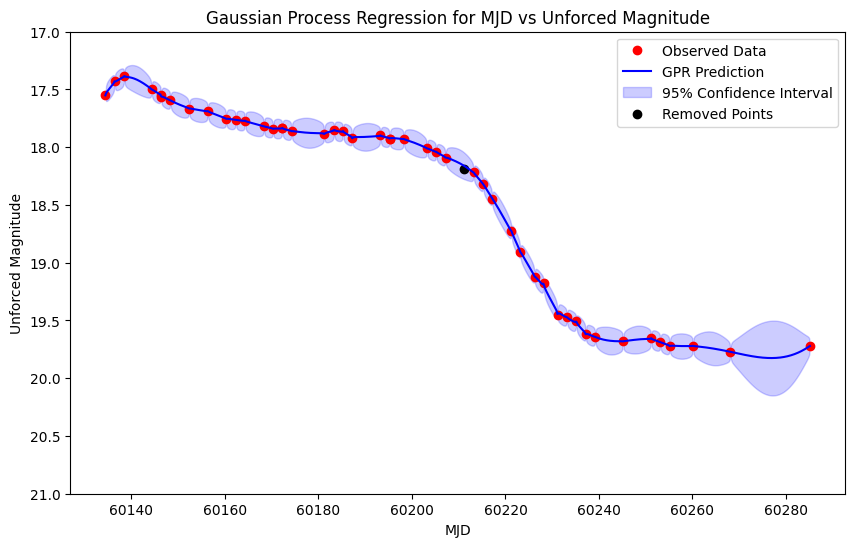

21


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Shock break out time =  60276.83607806106


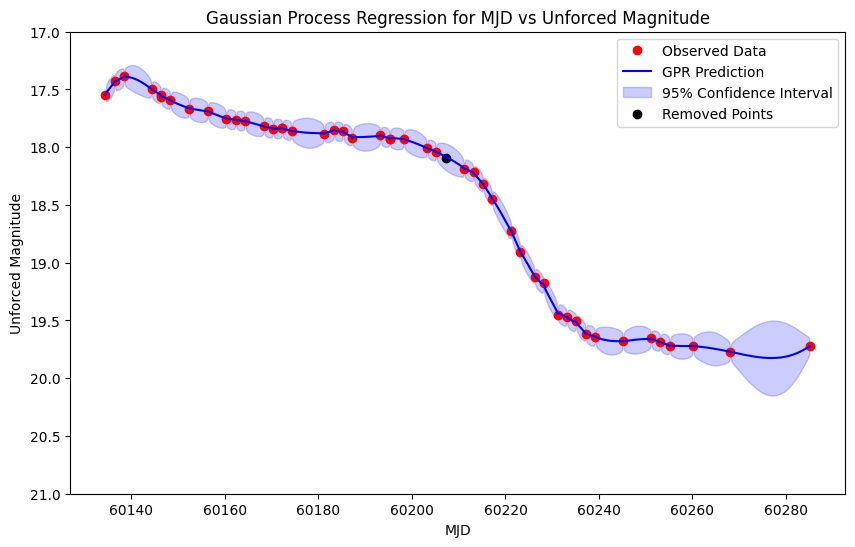

22


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Shock break out time =  60276.83607806106


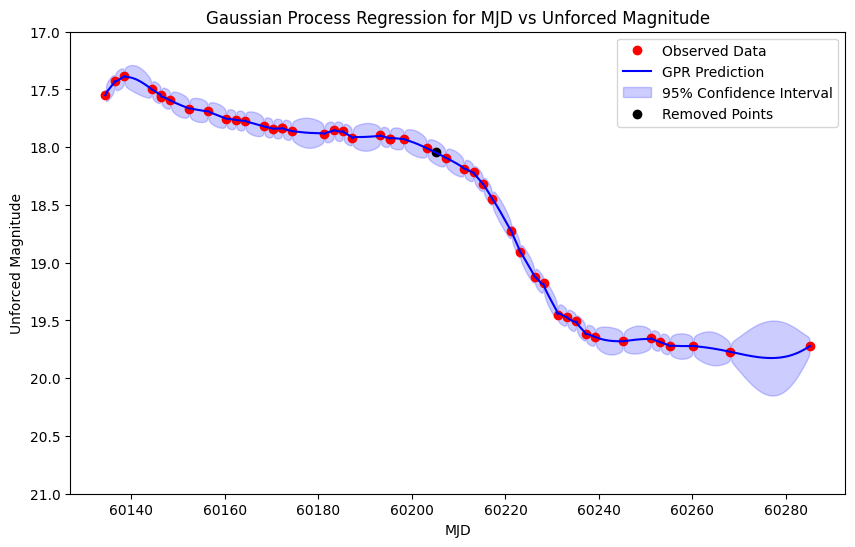

23
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


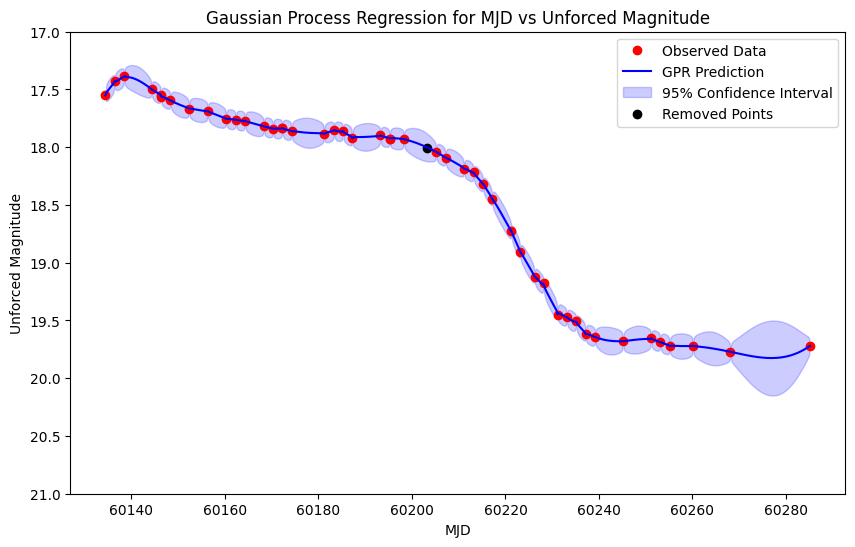

24
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


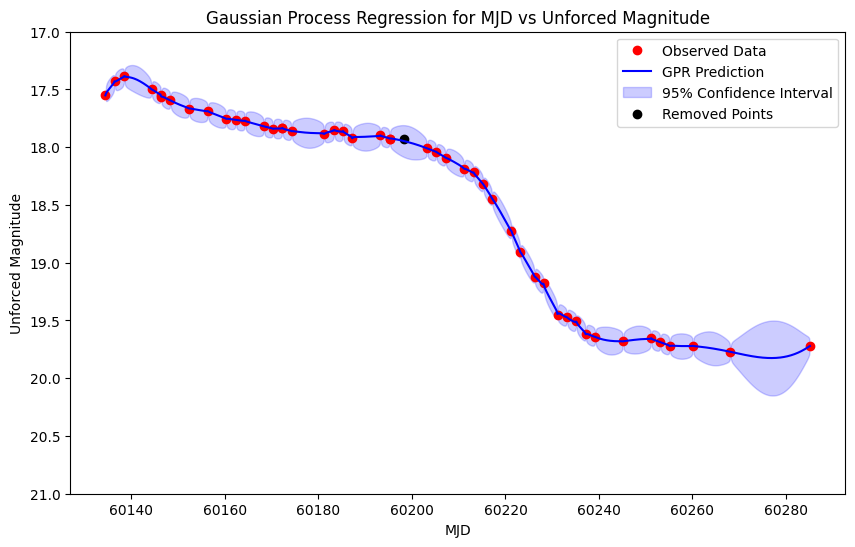

25
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


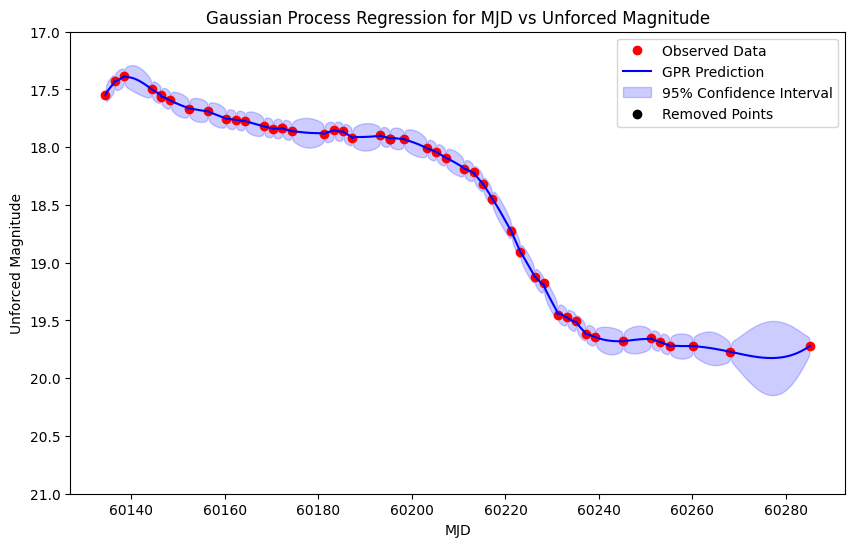

26
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


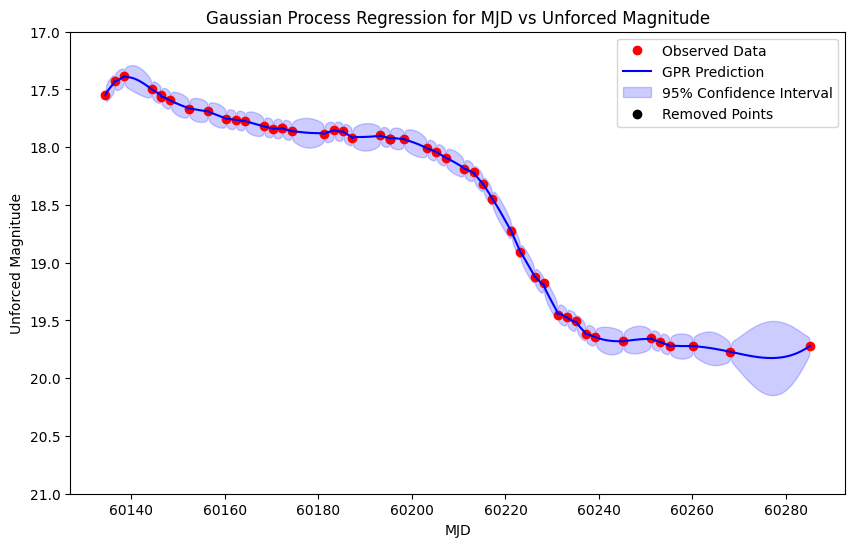

27
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


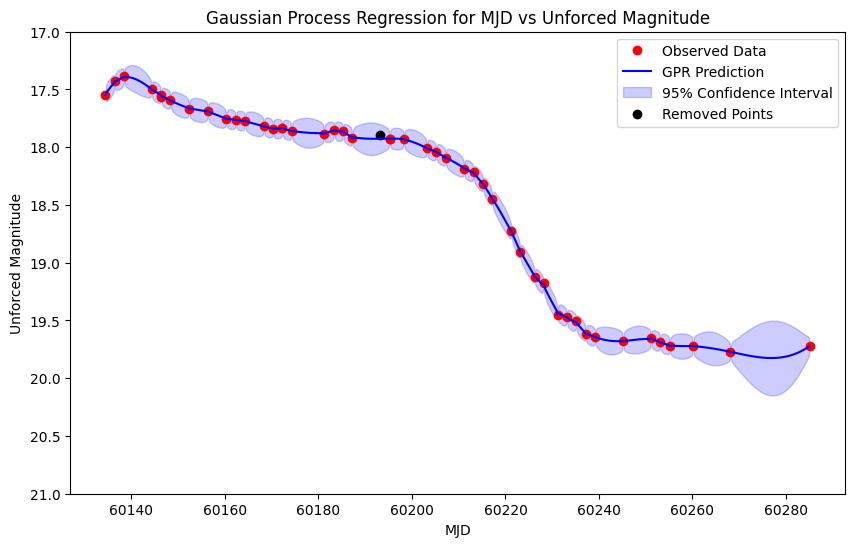

28
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


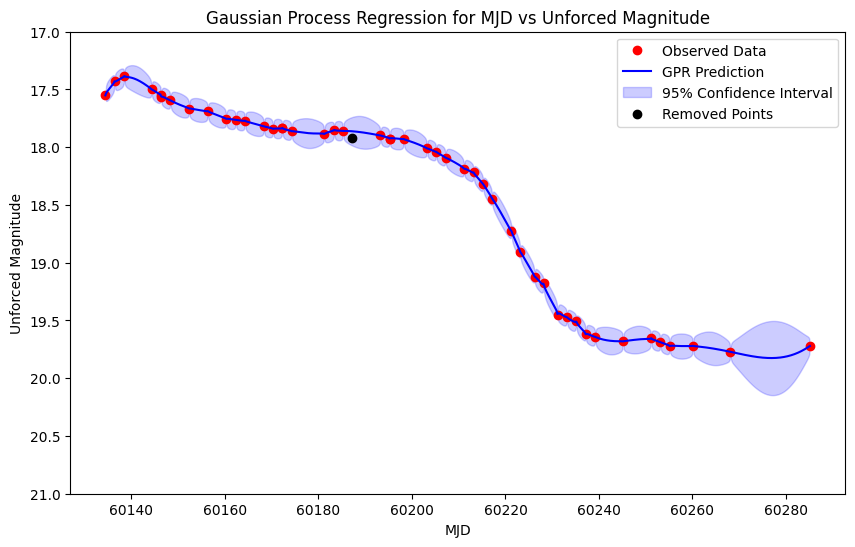

29
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


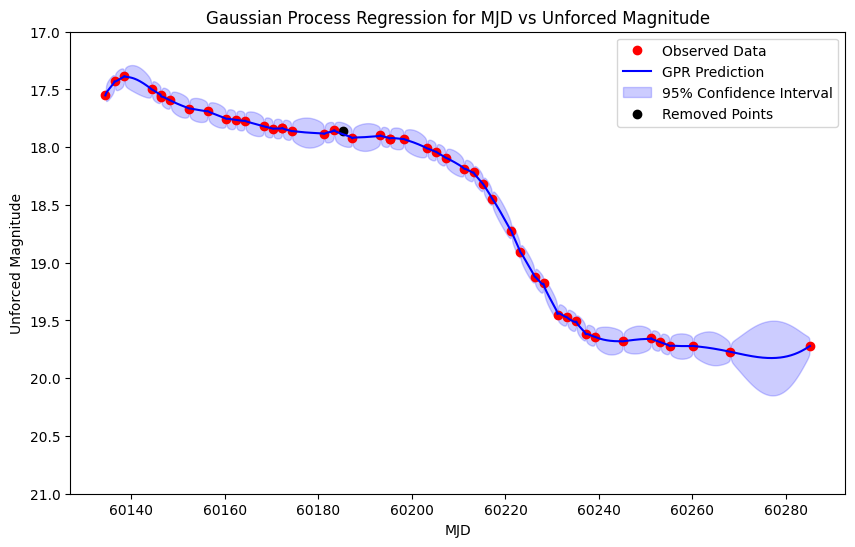

30
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


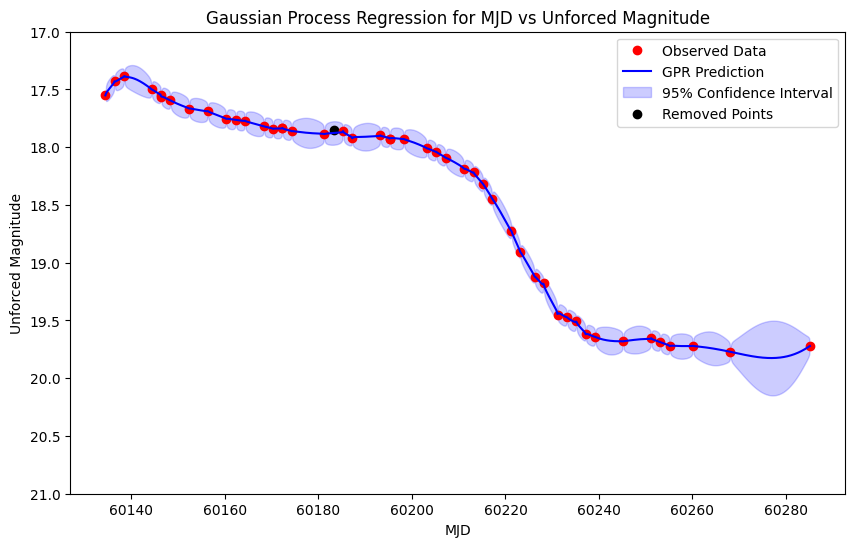

31
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


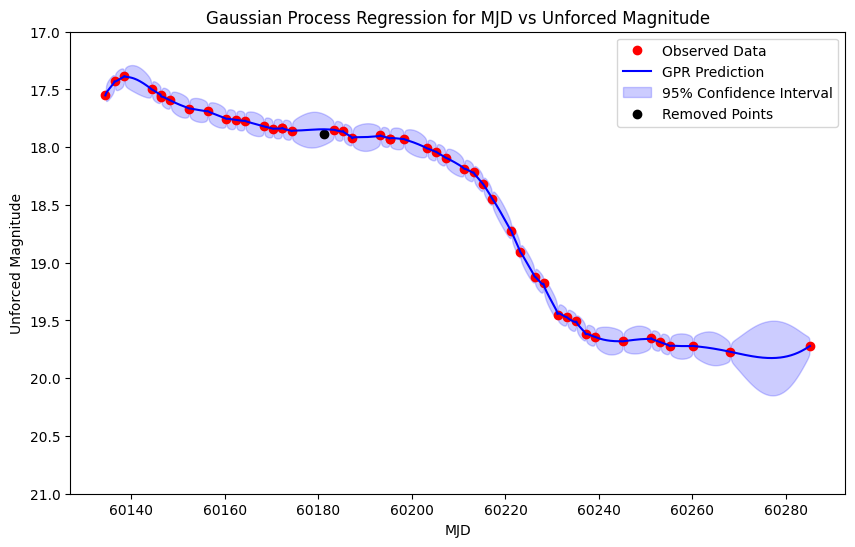

32
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


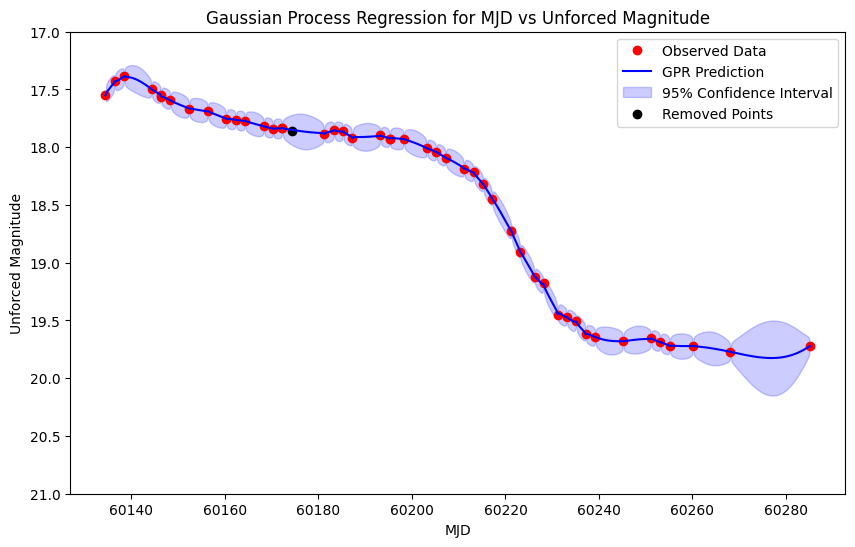

33
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


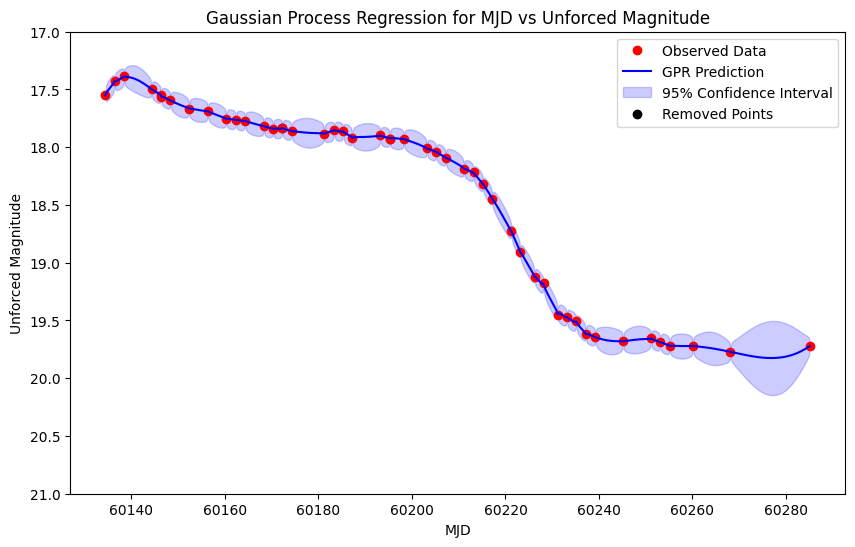

34
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


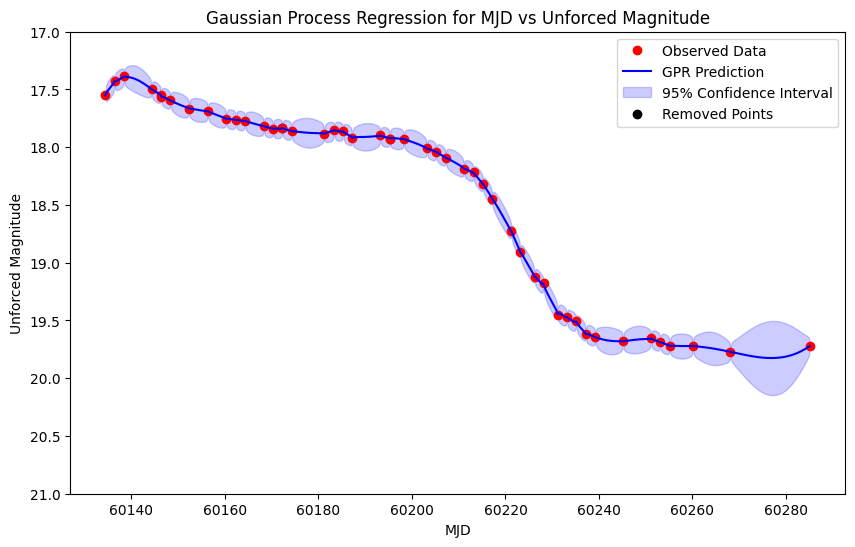

35
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


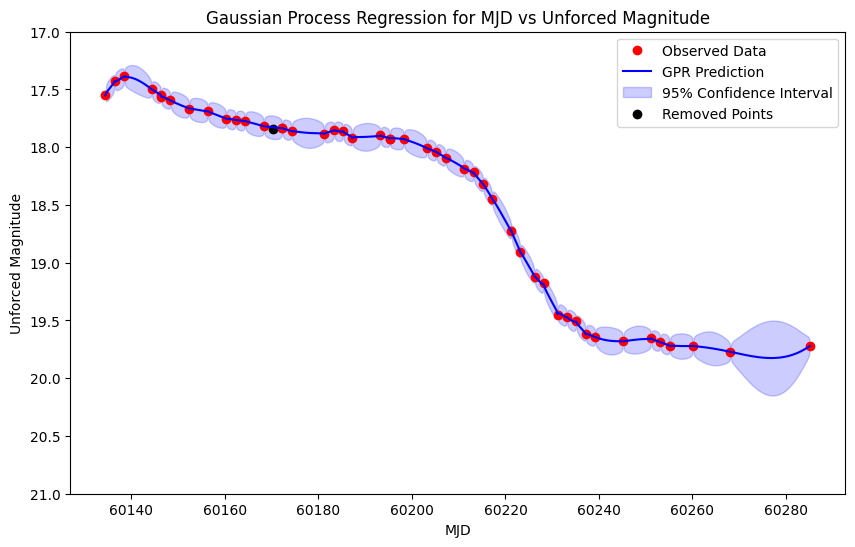

36
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


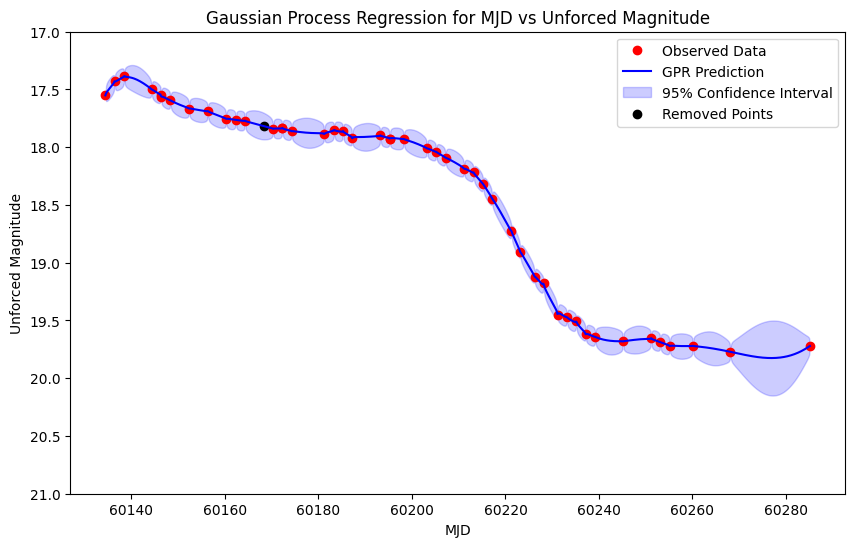

37
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


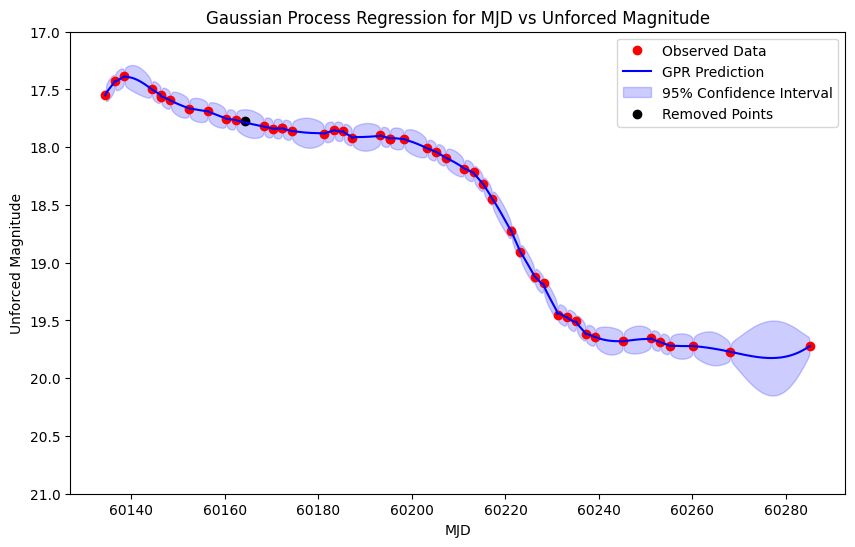

38
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


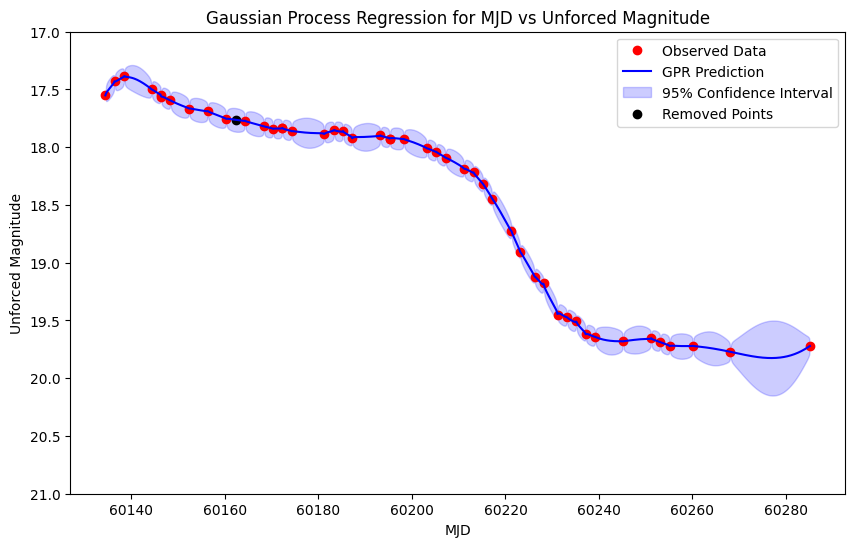

39
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


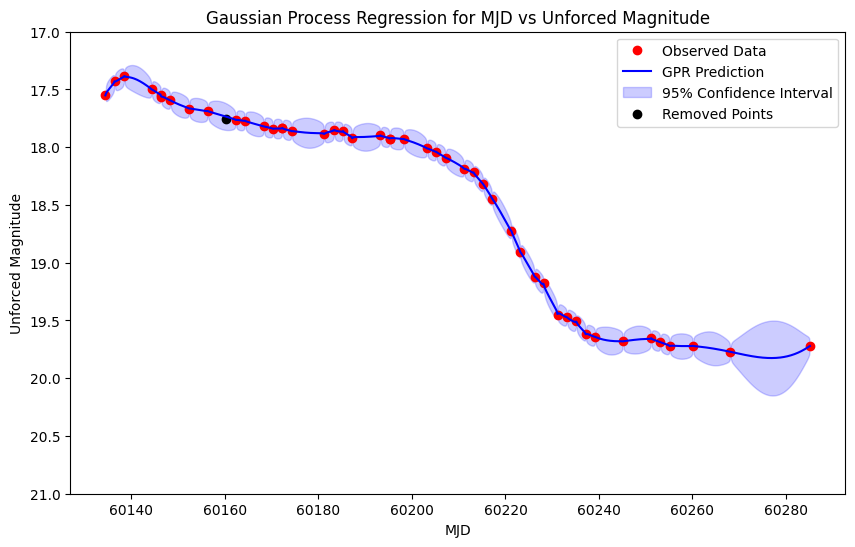

40
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


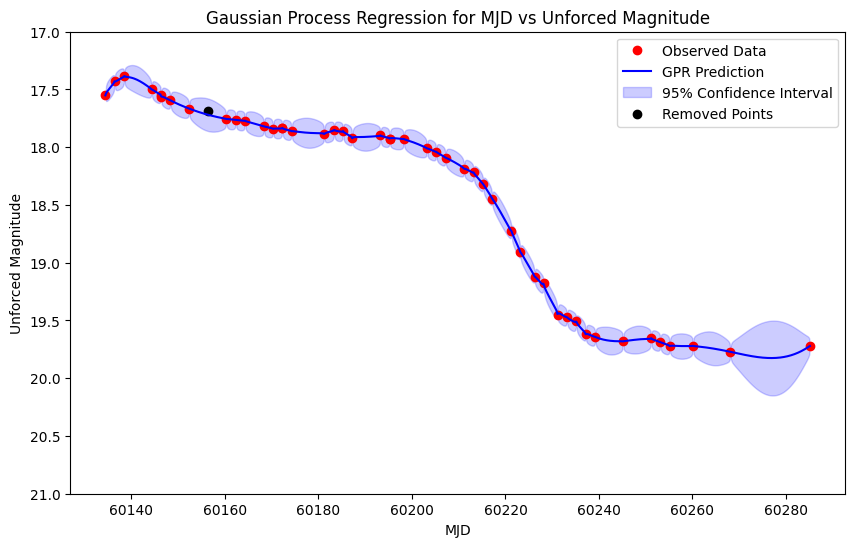

41
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


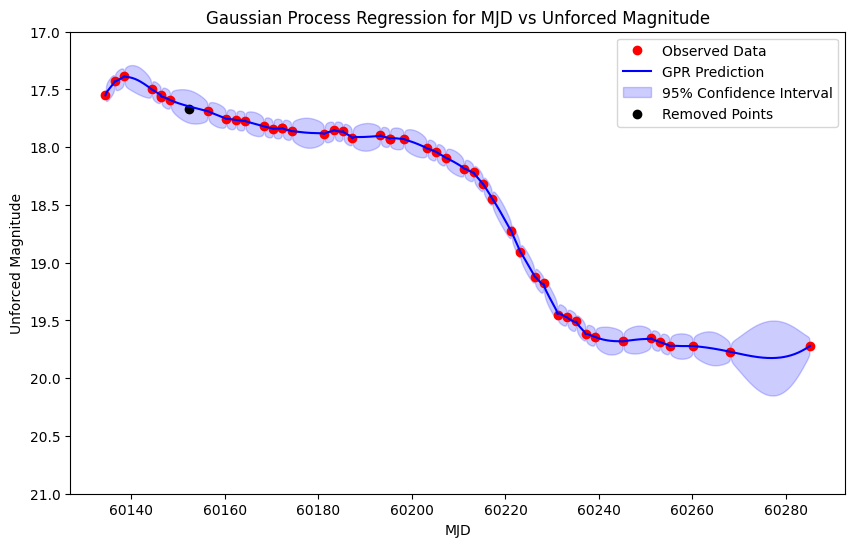

42
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


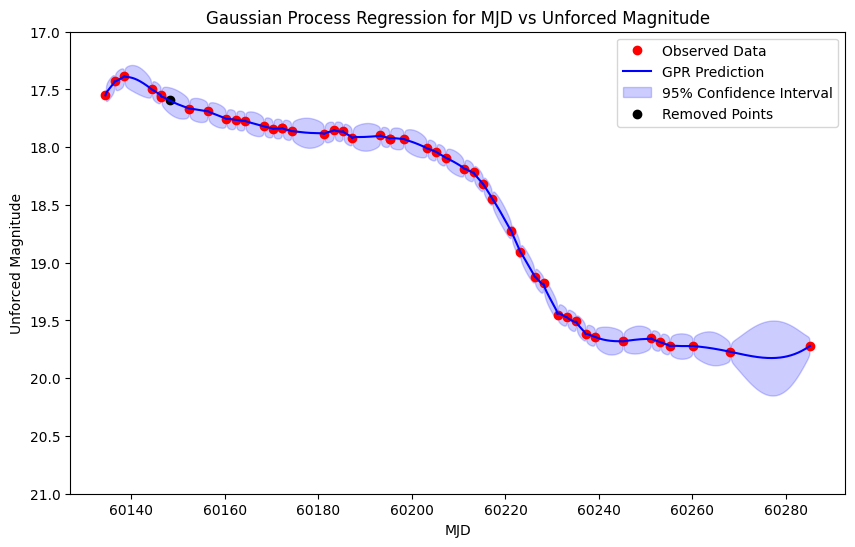

43
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/ke

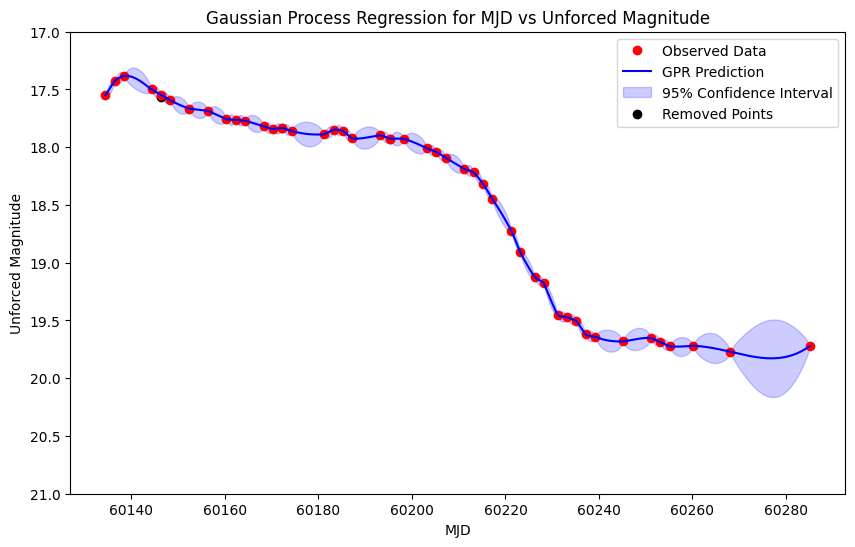

44
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


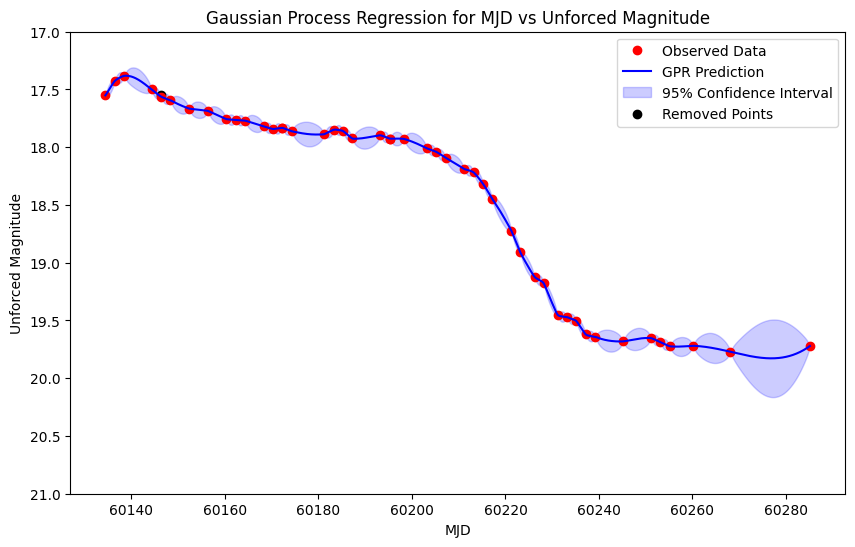

45
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


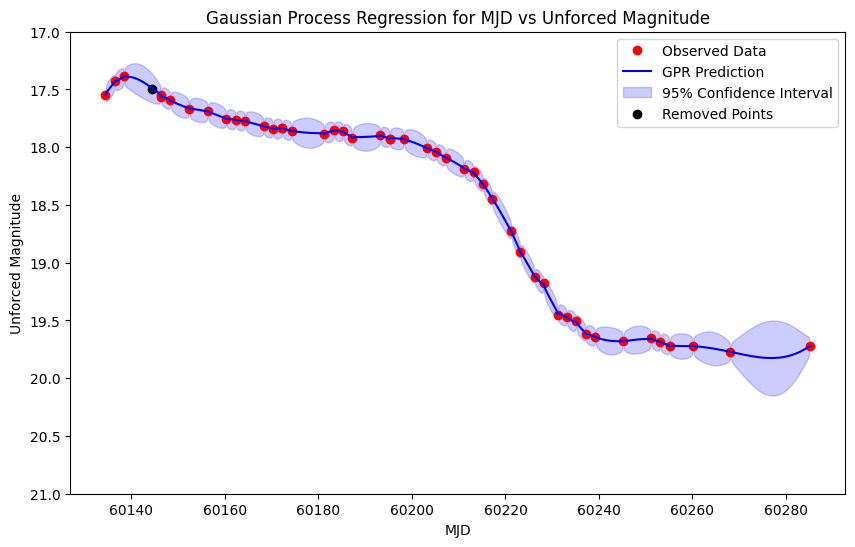

46
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


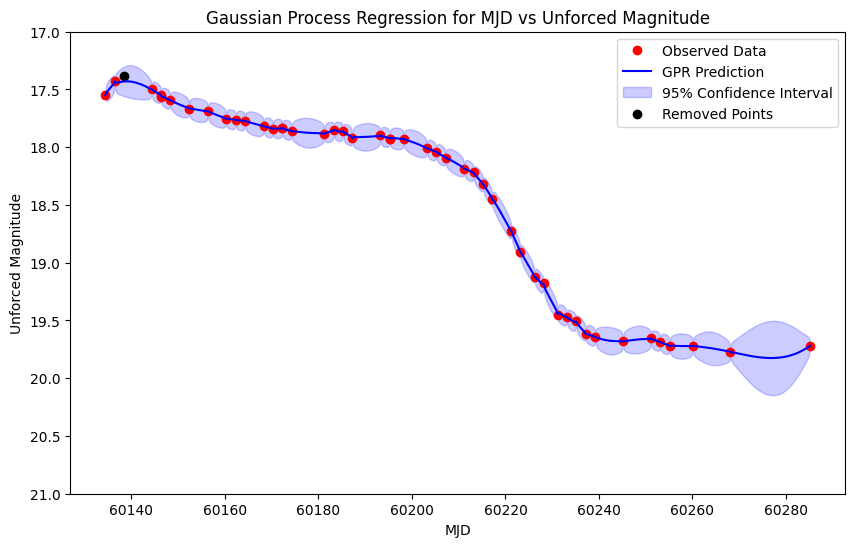

47
Shock break out time =  60276.83607806106


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


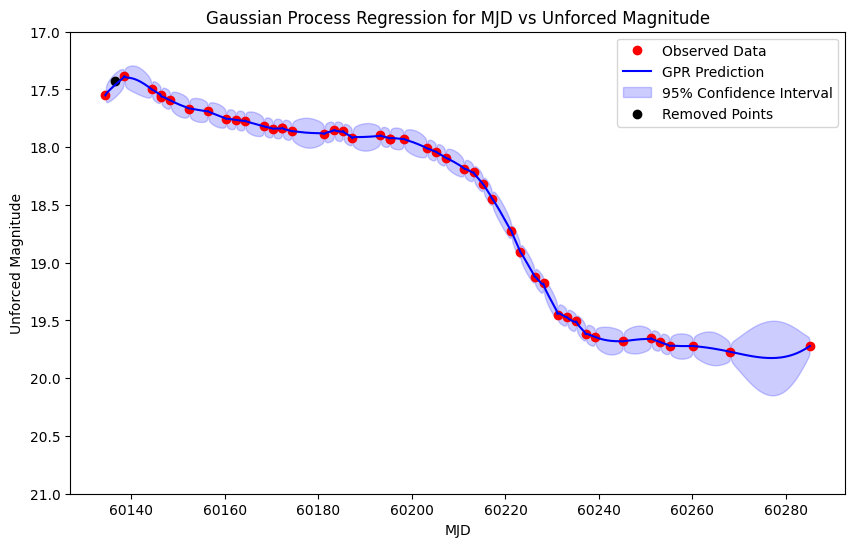

/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Shock break out time =  60141.36169283984


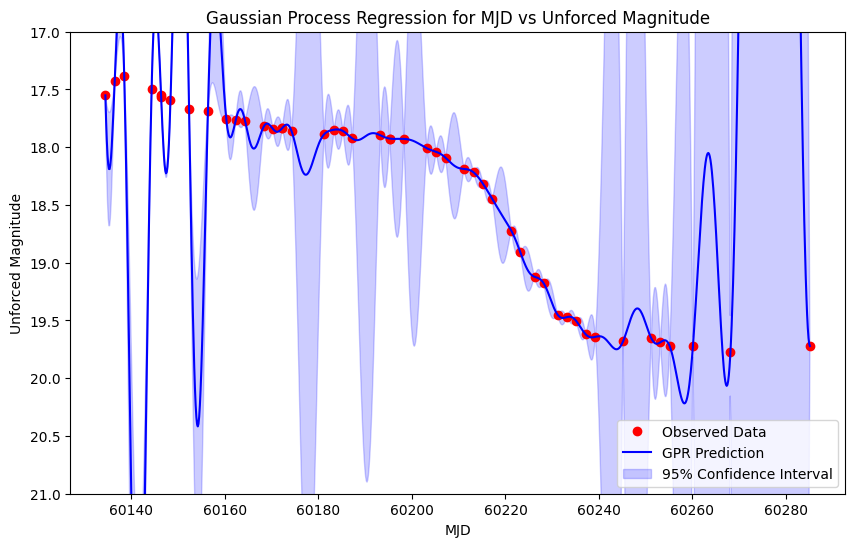

In [8]:
N_loop = int(input("Enter number of iterations: "))
N_remove = int(input("Enter number of points to remove per iteration (0 for Nonrandom Point Removal): "))
graphs = input("Print Graphs? (Yes or No): ")

t_sbo = []
t=0
i = 1

if N_remove == 0:
  while i <= N_loop:
      print(i)
      frg_r = frg_r_all.copy()
      reduced_set = nonrandom_point_removal(frg_r,i)
      X = reduced_set[['MJD']].values
      y = reduced_set[['unforced_mag']].values
      if graphs == 'Yes':
        t = GPR(X,y,True,False,N_loop)
      if graphs == 'No':
        t = GPR(X,y,False,False,N_loop)
      t_sbo.append(t)
      i += 1

else:
  while i <= N_loop:
      print(i)
      frg_r = frg_r_all.copy()
      X = frg_r_all[['MJD']].values
      y = frg_r_all[['unforced_mag']].values
      if graphs == 'Yes':
        t = GPR(X,y,True,True,N_loop)
      if graphs == 'No':
        t = GPR(X,y,False,True,N_loop)
      t_sbo.append(t)
      i+=1
X = frg_r_all[['MJD']].values
y = frg_r_all[['unforced_mag']].values
t= GPR_all(X,y,True)
t_sbo.append(t)

In [9]:
mean_t = np.mean(t_sbo)
print (mean_t)

# Calculate relative errors: (value - mean) / mean
relative_errors = (t_sbo - mean_t) / mean_t
print (relative_errors)

60273.80414844027
[-1.14070195e-04  4.27937580e-05  5.53085102e-05  5.03026093e-05
  5.03026093e-05  5.03026093e-05  5.03026093e-05  5.03026093e-05
  5.03026093e-05  5.03026093e-05  5.03026093e-05  5.03026093e-05
  5.03026093e-05  5.03026093e-05  5.03026093e-05  5.03026093e-05
  5.03026093e-05  5.03026093e-05  5.03026093e-05  5.03026093e-05
  5.03026093e-05  5.03026093e-05  5.03026093e-05  5.03026093e-05
  5.03026093e-05  5.03026093e-05  5.03026093e-05  5.03026093e-05
  5.03026093e-05  5.03026093e-05  5.03026093e-05  5.03026093e-05
  5.03026093e-05  5.03026093e-05  5.03026093e-05  5.03026093e-05
  5.03026093e-05  5.03026093e-05  5.03026093e-05  5.03026093e-05
  5.03026093e-05  5.03026093e-05  5.03026093e-05  5.03026093e-05
  5.03026093e-05  5.03026093e-05  5.03026093e-05 -2.19734688e-03]


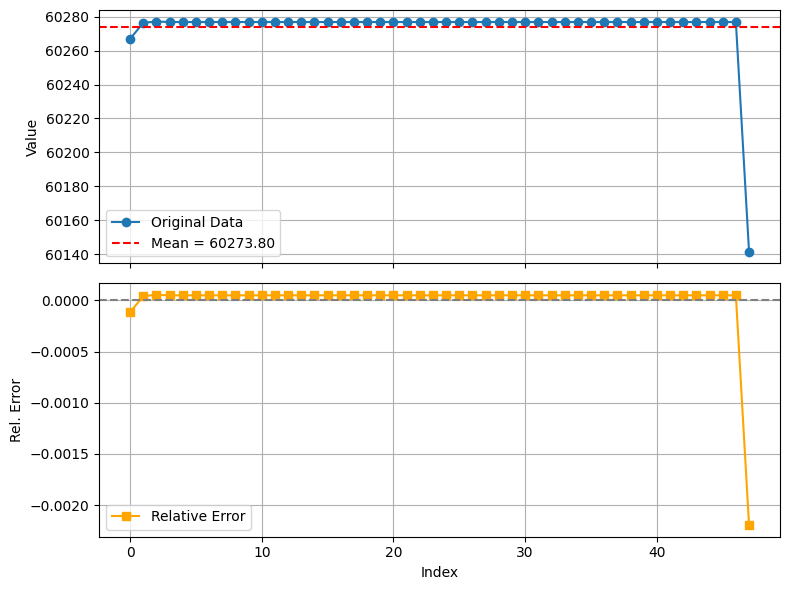

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Plot original data with mean
axs[0].plot(t_sbo, marker='o', label='Original Data')
axs[0].axhline(mean_t, color='red', linestyle='--', label=f'Mean = {mean_t:.2f}')
axs[0].set_ylabel('Value')
axs[0].legend()
axs[0].grid(True)

# Plot relative error
axs[1].plot(relative_errors, marker='s', color='orange', label='Relative Error')
axs[1].axhline(0, color='gray', linestyle='--')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Rel. Error')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

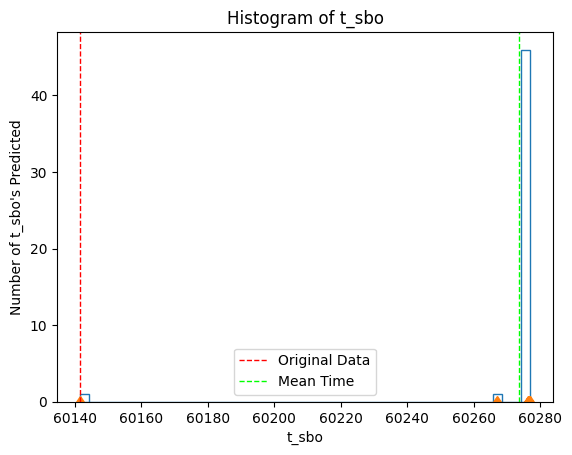

In [11]:
#make histogram, include plot without points removed and put line through that
num_bins=len(t_sbo)

#plt.hist(t_sbo, num_bins, weights=None, histtype='stepfilled')
style = {'facecolor': 'none', 'edgecolor': 'C0', 'linewidth': 1}

fig, ax = plt.subplots()
ax.hist(t_sbo, bins=num_bins, **style)
ax.plot(t_sbo, [0]*len(t_sbo), 'd')
ax.set_ylabel('Number of t_sbo\'s Predicted')
ax.set_xlabel('t_sbo')
ax.set_title('Histogram of t_sbo')
plt.axvline(t_sbo[-1], color='Red', linestyle='dashed', linewidth=1, label='Original Data')
plt.axvline(mean_t, color='lime', linestyle='dashed', linewidth=1, label='Mean Time')
ax.legend()

plt.show()